# **Learning Node Embeddings**

We will write a full pipeline for **learning node embeddings**.
We will go through the following 3 steps.

To start, we will load a classic graph in network science, the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). We will explore multiple graph statistics for that graph.

We will then transform the graph structure into a PyTorch tensor, so that we can perform machine learning over the graph.

Finally, we will finish the first learning algorithm on graphs: a node embedding model. For simplicity, our model here is simpler than DeepWalk / node2vec algorithms taught in the lecture. But it's still rewarding and challenging, as we will write it from scratch via PyTorch.

Now let's get started!

**Note**: Make sure to **sequentially run all the cells**, so that the intermediate variables / packages will carry over to the next cell

# 1 Graph Basics
To start, we will load a classic graph in network science, the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). We will explore multiple graph statistics for that graph.

## Setup
We will heavily use NetworkX in this Colab.

In [57]:
import matplotlib.pyplot as plt

In [58]:
G = nx.karate_club_graph()

# G is an undirected graph
type(G)

networkx.classes.graph.Graph

## Zachary's karate club network

The [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club.

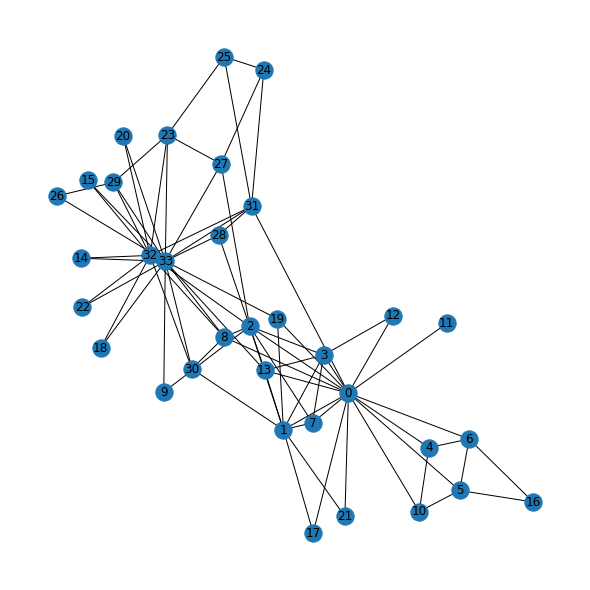

In [59]:
# Visualize the graph
# larger figure size
plt.figure(3,figsize=(8,8))
nx.draw(G, with_labels = True)
plt.show()

# 2 Graph to Tensor
We will then work together to transform the graph $G$ into a PyTorch tensor, so that we can perform machine learning over the graph.

## Setup
Check if PyTorch is properly installed

In [60]:
import torch
print(torch.__version__)

1.11.0


PyTorch tensor contains elements for a single data type, the `dtype`.

In [63]:
# Create a 3 x 4 tensor with all 32-bit floating point zeros
zeros = torch.zeros(3, 4, dtype=torch.float32)
print(zeros.dtype)

# Change the tensor dtype to 64-bit integer
zeros = zeros.type(torch.long)
print(zeros.dtype)

torch.float32
torch.int64


## Getting the edge list of the karate club network and transform it into `torch.LongTensor`. What is the `torch.sum` value of `pos_edge_index` tensor?

In [64]:
def graph_to_edge_list(G):
  # TODO: Implement the function that returns the edge list of
  # an nx.Graph. The returned edge_list should be a list of tuples
  # where each tuple is a tuple representing an edge connected 
  # by two nodes.

  edge_list = []

  ############# Your code here ############
  for edge in G.edges():
      edge_list.append(edge)
  #########################################

  return edge_list

def edge_list_to_tensor(edge_list):
  # TODO: Implement the function that transforms the edge_list to
  # tensor. The input edge_list is a list of tuples and the resulting
  # tensor should have the shape [2 x len(edge_list)].

  edge_index = torch.tensor([])

  ############# Your code here ############
  edge_index = torch.tensor(edge_list).T
  #########################################

  return edge_index

pos_edge_list = graph_to_edge_list(G)
# print(pos_edge_list)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


## Samples negative edges. Then answer which edges (edge_1 to edge_5) can be negative ones in the karate club network? (10 Points)

In [65]:
import random

def sample_negative_edges(G, num_neg_samples):
  # TODO: Implement the function that returns a list of negative edges.
  # The number of sampled negative edges is num_neg_samples. You do not
  # need to consider the corner case when the number of possible negative edges
  # is less than num_neg_samples. It should be ok as long as your implementation 
  # works on the karate club network. In this implementation, self loop should 
  # not be considered as either a positive or negative edge. Also, notice that 
  # the karate club network is an undirected graph, if (0, 1) is a positive 
  # edge, do you think (1, 0) can be a negative one?

  neg_edge_list = []

  ############# Your code here ############
  pos_edge_list = graph_to_edge_list(G)
  for node1 in G.nodes():
      for node2 in G.nodes():
          if node1 >= node2:
              continue
          if (node1, node2) in pos_edge_list:
              continue
          neg_edge_list.append((node1, node2))
  neg_edge_list = random.sample(neg_edge_list, num_neg_samples)
  #########################################

  return neg_edge_list

# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

## Note:
## 1: For each of the 5 edges, print whether it can be negative edge
pos_edge_list = graph_to_edge_list(G)
for edge in [edge_1, edge_2, edge_3, edge_4, edge_5]:
    edge = (edge[1], edge[0]) if edge[0] > edge[1] else edge
    if edge in pos_edge_list:
        print("No")
    else:
        print("Yes")

#########################################

The neg_edge_index tensor has shape torch.Size([2, 78])
No
Yes
No
No
Yes


# 3 Node Emebedding Learning

Finally, we will finish the first learning algorithm on graphs: a node embedding model.


## Setup

In [70]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(torch.__version__)

1.11.0


To write our own node embedding learning methods, we'll heavily use the [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module in PyTorch. Let's see how to use `nn.Embedding`:

In [71]:
# Initialize an embedding layer
# Suppose we want to have embedding for 4 items (e.g., nodes)
# Each item is represented with 8 dimensional vector

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


We can select items from the embedding matrix, by using Tensor indices

In [72]:
# Select an embedding in emb_sample
id = torch.LongTensor([1])
print(emb_sample(id))

# Select multiple embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# Get the shape of the embedding weight matrix
shape = emb_sample.weight.data.shape
print(shape)

# Overwrite the weight to tensor with all ones
emb_sample.weight.data = torch.ones(shape)

# Let's check if the emb is indeed initilized
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[ 0.5733, -1.0423,  1.1362, -1.9532, -0.5476,  0.0296, -1.9682, -0.1432]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 0.5733, -1.0423,  1.1362, -1.9532, -0.5476,  0.0296, -1.9682, -0.1432],
        [ 0.2189,  0.7310, -0.9124,  0.7659,  0.3567,  0.0277, -0.8318, -1.8371]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


Now, it's your time to create node embedding matrix for the graph we have!
- We want to have **16 dimensional** vector for each node in the karate club network.
- We want to initalize the matrix under **uniform distribution**, in the range of $[0, 1)$. We suggest you using [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html).

In [73]:
# Please do not change / reset the random seed
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
  # TODO: Implement this function that will create the node embedding matrix.
  # A torch.nn.Embedding layer will be returned. You do not need to change 
  # the values of num_node and embedding_dim. The weight matrix of returned 
  # layer should be initialized under uniform distribution. 

  emb = None

  ############# Your code here ############
  emb = nn.Embedding(num_embeddings=num_nodes, embedding_dim=embedding_dim)
  shape = emb.weight.data.shape
  emb.weight.data = torch.rand(shape)
  #########################################

  return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# Print the embedding layer
print("Embedding: {}".format(emb))

# An example that gets the embeddings for node 0 and 3
print(emb(ids))

Embedding: Embedding(52, 16)
tensor([[0.5380, 0.0158, 0.7648, 0.3487, 0.9465, 0.0169, 0.3830, 0.8878, 0.7163,
         0.2505, 0.0670, 0.4946, 0.6932, 0.0849, 0.0816, 0.4937],
        [0.3395, 0.1577, 0.6533, 0.8562, 0.8886, 0.1901, 0.7726, 0.8553, 0.5056,
         0.7109, 0.7829, 0.8826, 0.7675, 0.7134, 0.3102, 0.2212]],
       grad_fn=<EmbeddingBackward0>)


## Visualize the initial node embeddings
One good way to understand an embedding matrix, is to visualize it in a 2D space.
Here, we have implemented an embedding visualization function for you.
We first do PCA to reduce the dimensionality of embeddings to a 2D space.
Then visualize each point, colored by the community it belongs to.

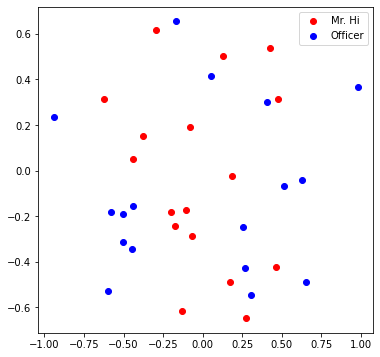

In [74]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

## Training the embedding! What is the best performance you can get? Please report both the best loss and accuracy on Gradescope. (20 Points)

In [75]:
from torch.optim import SGD

def accuracy(pred, label):
  # TODO: Implement the accuracy function. This function takes the 
  # pred tensor (the resulting tensor after sigmoid) and the label 
  # tensor (torch.LongTensor). Predicted value greater than 0.5 will 
  # be classified as label 1. Else it will be classified as label 0.
  # The returned accuracy should be rounded to 4 decimal places. 
  # For example, accuracy 0.82956 will be rounded to 0.8296.

  accu = 0.0

  ############# Your code here ############
  accu = torch.sum(torch.round(pred) == label) / pred.shape[0]
  #########################################

  return accu

def train(emb, loss_fn, sigmoid, train_label, train_edge):
  # TODO: Train the embedding layer here. You can also change epochs and 
  # learning rate. In general, you need to implement: 
  # (1) Get the embeddings of the nodes in train_edge
  # (2) Dot product the embeddings between each node pair
  # (3) Feed the dot product result into sigmoid
  # (4) Feed the sigmoid output into the loss_fn
  # (5) Print both loss and accuracy of each epoch 
  # (as a sanity check, the loss should decrease during training)

  epochs = 500
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):

    ############# Your code here ############
    optimizer.zero_grad()
    node_emb = emb(train_edge)
    dot_product = torch.sum(node_emb[0] * node_emb[1], -1)
    result = sigmoid(dot_product)
    loss = loss_fn(result, train_label)
    print("Epoch:", i, "Loss:", loss.item(), 
          "Acc:", accuracy(result, train_label).item())
    loss.backward()
    optimizer.step()
    #########################################

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

train(emb, loss_fn, sigmoid, train_label, train_edge)

Epoch: 0 Loss: 2.035567045211792 Acc: 0.5
Epoch: 1 Loss: 2.022132158279419 Acc: 0.5
Epoch: 2 Loss: 1.9968163967132568 Acc: 0.5
Epoch: 3 Loss: 1.9611926078796387 Acc: 0.5
Epoch: 4 Loss: 1.9168115854263306 Acc: 0.5
Epoch: 5 Loss: 1.8651845455169678 Acc: 0.5
Epoch: 6 Loss: 1.8077572584152222 Acc: 0.5
Epoch: 7 Loss: 1.7458972930908203 Acc: 0.5
Epoch: 8 Loss: 1.680883765220642 Acc: 0.5
Epoch: 9 Loss: 1.6138982772827148 Acc: 0.5
Epoch: 10 Loss: 1.5460177659988403 Acc: 0.5
Epoch: 11 Loss: 1.4782098531723022 Acc: 0.5
Epoch: 12 Loss: 1.4113250970840454 Acc: 0.5
Epoch: 13 Loss: 1.3460941314697266 Acc: 0.5
Epoch: 14 Loss: 1.2831242084503174 Acc: 0.5
Epoch: 15 Loss: 1.2228999137878418 Acc: 0.5
Epoch: 16 Loss: 1.1657840013504028 Acc: 0.5
Epoch: 17 Loss: 1.1120245456695557 Acc: 0.5
Epoch: 18 Loss: 1.0617632865905762 Acc: 0.5
Epoch: 19 Loss: 1.0150479078292847 Acc: 0.5
Epoch: 20 Loss: 0.9718466401100159 Acc: 0.5
Epoch: 21 Loss: 0.9320628643035889 Acc: 0.5
Epoch: 22 Loss: 0.8955503702163696 Acc: 0.5
E

## Visualize the final node embeddings
Visualize your final embedding here! 
You can visually compare the figure with the previous embedding figure. 
After training, you should oberserve that the two classes are more evidently separated. 
This is a great sanitity check for your implementation as well.

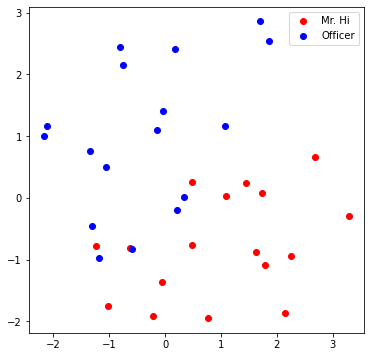

In [76]:
# Visualize the final learned embedding
visualize_emb(emb)